# Lab Deep Learning/ Recurrent Neural Networks/ in keras

## Training language model (Many-to-Many) and generating sequences (One-to-Many)

**Author: geoffroy.peeters@telecom-paris.fr**

For any remark or suggestion, please feel free to contact me.


## Objective:

- We will train a network to learn a language model and then use it to generate new sequences.

- Instead of training the language model on text-documents (as it is the case in most examples) we will train it to learn the language of the music of [Johann_Sebastian_Bach](https://en.wikipedia.org/wiki/Johann_Sebastian_Bach).
For this, we will learn how J. S. Bach's "Cello suite" have been composed.
Here is an example of a "Cello suite" [Link](https://www.youtube.com/watch?v=mGQLXRTl3Z0).

- Rather than analyzing the audio signal, we use a symbolic representation of the "Cello suite" through their [MIDI files](https://en.wikipedia.org/wiki/MIDI#MIDI_files).
  - A MIDI file encodes in a file, the set of musical notes, their duration, and intensity which have to be played by each instrument to "render" a musical piece. The "rendering" is usually operated by a MIDI synthesizer (such as VLC, QuickTime).

- We will first train a language model on the whole set of MIDI files of the "Cello suites". 
- We will then sample this language model to create a new MIDI file which will be a brand new "Cello suite" composed by the computer.

### Questions:

In the bottom part of this lab, you will have to answer a set of questions. Answers to those only necessitates a couple of sentences.

## Import packages

In [0]:
import os
import pretty_midi
from scipy.io import wavfile 
import IPython

from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Flatten, Dropout, Activation
from keras import Model
from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
import glob

student = True
download = False

Using TensorFlow backend.


# Get the data

In [0]:
n_x = 79
max_T_x = 1000
sequence_length = 25
T_y_generated = 200

## Collect data to create the language model

We download the 36 MIDI files corresponding to the 36 "Cello suites" composed by J. S. Bach.

In [0]:
if download:
  import urllib.request
  for midiFile in midiFile_l:
    #if os.path.isfile(DIR + midiFile) is None:
    urllib.request.urlretrieve ("http://www.jsbach.net/midi/" + midiFile, DIR + midiFile)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
midiFile_l = ['cs1-2all.mid', 'cs5-1pre.mid', 'cs4-1pre.mid', 'cs3-5bou.mid', 'cs1-4sar.mid', 'cs2-5men.mid', 'cs3-3cou.mid', 'cs2-3cou.mid', 'cs1-6gig.mid', 'cs6-4sar.mid', 'cs4-5bou.mid', 'cs4-3cou.mid', 'cs5-3cou.mid', 'cs6-5gav.mid', 'cs6-6gig.mid', 'cs6-2all.mid', 'cs2-1pre.mid', 'cs3-1pre.mid', 'cs3-6gig.mid', 'cs2-6gig.mid', 'cs2-4sar.mid', 'cs3-4sar.mid', 'cs1-5men.mid', 'cs1-3cou.mid', 'cs6-1pre.mid', 'cs2-2all.mid', 'cs3-2all.mid', 'cs1-1pre.mid', 'cs5-2all.mid', 'cs4-2all.mid', 'cs5-5gav.mid', 'cs4-6gig.mid', 'cs5-6gig.mid', 'cs5-4sar.mid', 'cs4-4sar.mid', 'cs6-3cou.mid']
nbExample = len(midiFile_l)
DIR = 'drive/My Drive/data/'
midiFile_l = glob.glob(DIR + 'cs*.mid')
print(midiFile_l)

['drive/My Drive/data/cs1-1pre.mid', 'drive/My Drive/data/cs2-1pre.mid', 'drive/My Drive/data/cs1-6gig.mid', 'drive/My Drive/data/cs2-2all.mid', 'drive/My Drive/data/cs2-3cou.mid', 'drive/My Drive/data/cs1-5men.mid', 'drive/My Drive/data/cs1-4sar.mid', 'drive/My Drive/data/cs2-4sar.mid', 'drive/My Drive/data/cs1-3cou.mid', 'drive/My Drive/data/cs1-2all.mid', 'drive/My Drive/data/cs2-5men.mid', 'drive/My Drive/data/cs2-6gig.mid', 'drive/My Drive/data/cs3-2all.mid', 'drive/My Drive/data/cs3-1pre.mid', 'drive/My Drive/data/cs3-3cou.mid', 'drive/My Drive/data/cs3-4sar.mid', 'drive/My Drive/data/cs4-2all.mid', 'drive/My Drive/data/cs3-6gig.mid', 'drive/My Drive/data/cs3-5bou.mid', 'drive/My Drive/data/cs4-1pre.mid', 'drive/My Drive/data/cs4-3cou.mid', 'drive/My Drive/data/cs4-6gig.mid', 'drive/My Drive/data/cs5-2all.mid', 'drive/My Drive/data/cs4-5bou.mid', 'drive/My Drive/data/cs4-4sar.mid', 'drive/My Drive/data/cs5-1pre.mid', 'drive/My Drive/data/cs5-5gav.mid', 'drive/My Drive/data/cs5-6g

## Read and convert all MIDI files

In [0]:
# --- Read a single MIDI file
midi_data = pretty_midi.PrettyMIDI(midiFile_l[0])
# --- Display the note pitch, start, end and duration
for note in midi_data.instruments[0].notes:
    print('pitch: %d, start: %f, end: %f, duration: %f' % (note.pitch, note.start, note.end, note.end-note.start))

pitch: 43, start: 0.000000, end: 0.187500, duration: 0.187500
pitch: 50, start: 0.187500, end: 0.375000, duration: 0.187500
pitch: 59, start: 0.375000, end: 0.562500, duration: 0.187500
pitch: 57, start: 0.562500, end: 0.750000, duration: 0.187500
pitch: 59, start: 0.750000, end: 0.937500, duration: 0.187500
pitch: 50, start: 0.937500, end: 1.125000, duration: 0.187500
pitch: 59, start: 1.125000, end: 1.312500, duration: 0.187500
pitch: 50, start: 1.312500, end: 1.500000, duration: 0.187500
pitch: 43, start: 1.500000, end: 1.687500, duration: 0.187500
pitch: 50, start: 1.687500, end: 1.875000, duration: 0.187500
pitch: 59, start: 1.875000, end: 2.062500, duration: 0.187500
pitch: 57, start: 2.062500, end: 2.250000, duration: 0.187500
pitch: 59, start: 2.250000, end: 2.437500, duration: 0.187500
pitch: 50, start: 2.437500, end: 2.625000, duration: 0.187500
pitch: 59, start: 2.625000, end: 2.812500, duration: 0.187500
pitch: 50, start: 2.812500, end: 3.000000, duration: 0.187500
pitch: 4

We read all MIDI files and convert their content to one-hot-encoding matrix X_ohe of dimensions (T_x, n_x) where n_x is the number of possible musical notes.
The duration of the sequences T_x can vary from one sequence to the other.
 


In [0]:
# --- We truncate the duration of each example to the first T_x data

X_list = []

for midiFile in midiFile_l:
    # read the MIDI file
    midi_data = pretty_midi.PrettyMIDI(midiFile)
    note_l = [note.pitch for note in midi_data.instruments[0].notes]
    # convert to one-hot-encoding
    T_x = len(note_l)
    if T_x > max_T_x:
        T_x = max_T_x
    X_ohe = np.zeros((T_x, n_x))
    for t in range(T_x): 
        X_ohe[t, note_l[t]-1] = 1
    # add to the list  
    X_list.append(X_ohe)
    
print(len(X_list))
print(X_list[0].shape)
print(X_list[1].shape)
print(X_list[2].shape)

36
(593, 79)
(634, 79)
(420, 79)


## Display the set of notes over time for a specific track 

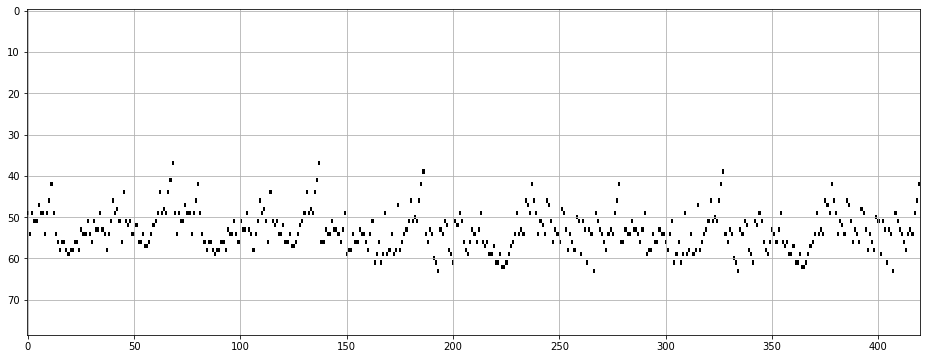

In [0]:
plt.figure(figsize=(16, 6))
plt.imshow(X_list[2].T, aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

## Data conversion for the training of language model

For each example/sequence and each possible starting note in this example/sequence, we create two sequences
- an input sequence: 
  - which contains a sub-sequence of length ```sequence_length```;  this sub-sequence range from the note $t$ to the note $t+sequence\_length-1$
- an output sequence:
  - which contains the following note to be predicted, the one at position $t+sequence\_length$

The training is therefore performed by giving to the model a set of sequences as input and asking the network to predict each time the note that should come right after this sequence.

In [0]:
X_train_list = []
y_train_list = []
if student:
    # --- START CODE HERE (01)
    X_train_list = [X_list[i][t:t+sequence_length] for i in range(len(X_list)) for t in range(len(X_list[i])-sequence_length)]
    y_train_list = [X_list[i][t+sequence_length] for i in range(len(X_list)) for t in range(len(X_list[i])-sequence_length)]
    # --- END CODE HERE
    
X_train = np.asarray(X_train_list)
y_train = np.asarray(y_train_list)

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (23601, 25, 79)
y_train.shape: (23601, 79)


# Training the language model


The language model will be learned by training an RNN with input `X_train` and output `Y_train`:  for each of the examples of sequences, we give to the network a sequence of notes of `sequence_length` duration, and ask the network to predict the following note of each sequence.

The network will have the following structure
- (1a) a layer of `LSTM` with $n_a$=256
- (1b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (2a) a layer of `LSTM` with $n_a$=256
- (2b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (3) a layer of `LSTM` with $n_a$=256
- (4a) a layer of `Dense` with 256 units
- (4b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (5) a layer of `Dense` with a `softmax` activation which predict the probability of each of the $n_x$ notes as output

## Returning the hidden states at each time of an LSTM cell

Note that when we stack one LSTM layer on top of a second LSTM layer (deep-RNN), we need to tell the first LSTM to output its hidden states at each time $t$. This is done by the option `return_sequences=True` that has to be given as parameter to the LSTM on top of the other one.
This is the case for (1a) and (2a).

However, since we are only interrested in the last hidden state of the third LSTM (since we are only interrest in its prediction at time $T_x$), we give the option `return_sequences=False` (which is the default behaviour) for the third LSTM.
This is the case for (3).

In [0]:
# --- Create the model
K.clear_session()

if student:
    # --- START CODE HERE (02)
    inputs    = Input(shape=(sequence_length,n_x,))
    
    output_1a = LSTM(256,return_sequences=True)(inputs)
    output_1b = Dropout(0.3)(output_1a)
    output_2a = LSTM(256,return_sequences=True)(output_1b)
    output_2b = Dropout(0.3)(output_2a)
    output_3  = LSTM(256)(output_2b)
    output_4a = Dense(256)(output_3)
    output_4b = Dropout(0.3)(output_4a)
    output_5  = Dense(n_x,activation='softmax')(output_4b)

    model     = Model(inputs=inputs, outputs=output_5)
    # --- END CODE HERE

print(model.summary())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 79)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 25, 256)           344064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 25, 256)           525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_____

In [0]:
# --- Compile and fit the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/20
23601/23601 [==============================] - 65s 3ms/step - loss: 1.5132 - acc: 0.5271
Epoch 2/20
23601/23601 [==============================] - 63s 3ms/step - loss: 1.3105 - acc: 0.5939
Epoch 3/20
23601/23601 [==============================] - 62s 3ms/step - loss: 1.1275 - acc: 0.6448
Epoch 4/20
23601/23601 [==============================] - 62s 3ms/step - loss: 0.9552 - acc: 0.6987
Epoch 5/20
23601/23601 [==============================] - 62s 3ms/step - loss: 0.8167 - acc: 0.7444
Epoch 6/20
23601/23601 [==============================] - 62s 3ms/step - loss: 0.7000 - acc: 0.7800
Epoch 7/20
23601/23601 [==============================] - 62s 3ms/step - loss: 0.5987 - acc: 0.8111
Epoch 8/20
23601/23601 [==============================] - 62s 3ms/step - loss: 0.5287 - acc: 0.8317
Epoch 9/20
23601/23601 [==============================] - 62s 3ms/step - loss: 0.4646 - acc: 0.8542
Epoch 10/20
23601/23601 [==============================] - 61s 3ms/step - loss: 0.4084 - acc: 0.8686

# Generating a new sequence from sampling the language model

To generate a new sequence from the language model, we simply give it as input a random sequence of duration ```sequence_length```and ask the trained network to predict the output (using ```model.predict```). 

The output of the network is a vector of probability of dimension $n_x$ which represents the probability of each note to be the next note of the melody given as input.

From this vector, we select the note which has the maximum probability.

We then concatenate this new note (its one-hot-encoding representation) at the end of the input sequence.
We finally remove the first element of the input sequence to keep its duration constant (```sequence_length```).

Instead of providing a random sequence as input, we rather randomly select one sequence out of the 2880 sequences used for training.
We denote it by ```pattern```.



In [0]:
# --- Select a random starting pattern
start = np.random.randint(0, len(X_train_list)-1)
pattern = X_train_list[start]
print(start)
print(pattern.shape)
print(np.expand_dims(pattern, 0).shape)

22583
(25, 79)
(1, 25, 79)


In [0]:
note_l = []

prediction_l = []
# --- Generate T_y_generated notes
for note_index in range(T_y_generated):
    if student:
        # --- START CODE HERE (03)
        prediction = model.predict(np.expand_dims(pattern[note_index:,:], 0)) # vector of probabilities
        prediction_l.append(prediction)
        note = np.argmax(prediction, axis=1) # keep the note that have the highest probability
        note_l.append(note)
        note_ohe = np.zeros(79)
        note_ohe[note] = 1
        pattern = np.vstack((pattern, note_ohe))
        # --- END CODE HERE    


### Display the generated sequence

[array([59]), array([58]), array([68]), array([66]), array([65]), array([66]), array([68]), array([65]), array([66]), array([68]), array([70]), array([68]), array([66]), array([65]), array([63]), array([61]), array([60]), array([63]), array([61]), array([61]), array([46]), array([48]), array([49]), array([51]), array([53]), array([49]), array([55]), array([58]), array([51]), array([53]), array([55]), array([56]), array([58]), array([60]), array([61]), array([60]), array([58]), array([60]), array([61]), array([58]), array([60]), array([56]), array([68]), array([54]), array([56]), array([54]), array([53]), array([54]), array([53]), array([68]), array([66]), array([65]), array([63]), array([61]), array([59]), array([58]), array([59]), array([68]), array([59]), array([58]), array([59]), array([56]), array([50]), array([53]), array([58]), array([62]), array([65]), array([68]), array([66]), array([65]), array([66]), array([51]), array([53]), array([54]), array([56]), array([58]), array([61])

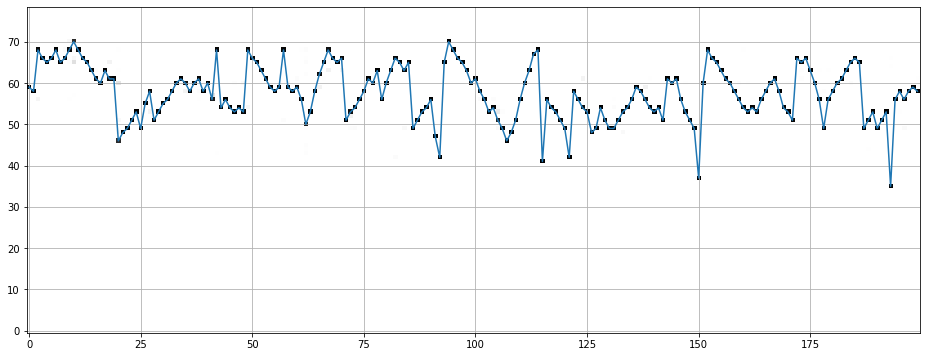

In [0]:
print(note_l)

plt.figure(figsize=(16, 6))
plt.imshow(np.asarray(prediction_l)[:,0,:].T, aspect='auto', origin='lower')
plt.plot(note_l)
plt.set_cmap('gray_r')
plt.grid(True)


### Create a MIDI file and an audio file which correspond to the generated sequence

Once the new sequence has been generated (```note_l```) we transform it to a new MIDI file and perform (a very cheap) rendering of it in an audio file.

In [0]:
new_midi_data = pretty_midi.PrettyMIDI()
cello_program = pretty_midi.instrument_name_to_program('Cello')
cello = pretty_midi.Instrument(program=cello_program)
time = 0
step = 0.3
for note_number in note_l:
    myNote = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+step)
    cello.notes.append(myNote)
    time += step
new_midi_data.instruments.append(cello)

In [0]:
%matplotlib inline

audio_data = new_midi_data.synthesize()
IPython.display.Audio(audio_data, rate=44100)

# Evaluation

To evaluate the work, you should rate the code for 
- 1) Data conversion for the training of language model (01)
- 2) Training the language model (02)
- 3) Generating a new sequence from sampling the language model (03)

You will also rate the answer to the four questions below.

## Question 1)

Que se passe-t'il si on remplace la cellule LSTM par une cellule RNN simple ?

**Réponse (en-dessous)** (1 points)

Sans cellule LSTM, il y a du vanishing gradient et donc le réseau de neurones ne peut pas apprendre des données trop lointaines dans le passé. Lors de la génération, on obtient alors des musiques répétitives (plusieurs fois les mêmes courtes séquences)

## Question 2) 

Que se passe-t'il si l'on raccourci la longueur des séquences utilisées pour l'entrainement ? Comment palier à cet effet ?

**Réponse (en-dessous)** (1 points)

Il se passe le même phénomène que sans cellule LSTM, si le réseau utilise de trop courtes séquences, les musiques prédites sont alors très répétitives. Il faudrait casser ces répétitions en, de temps en temps, choisir une note aléatoire.

## Question 3) 
Comment pourrait-on rendre le système ```polyphonique``` (plusieurs notes jouées simultanément par le même instrument) ? pour l'entrainement ? pour la génération ?

**Réponse (en-dessous)** (2 points)

Pour rendre le système polyphonique, au lieu d'utiliser un one-hot encoder on pourrait utiliser un two-hot encoder si on veut pouvoir coder 2 notes simultanément ou bien un many-hot encoder pour coder plusieurs notes simultanément.
Ensuite pour la prédiction, on ne garderait pas seulement la note qui a la plus haute probabilités mais plusieurs notes qui ont les plus hautes probabilités. Il faudrait donc également avoir un paramètre pour savoir combien de notes on garde à chaque pas de temps.

## Question 4) 

Nous avons utilisé une procédure simplifiée pour entrainer le modèle de language musical, en transformant l'apprentissage en un problème Many-To-one. Expliquez ? Comment entraine-t'on habituellement un modèle de language avec un RNN ? Quel en serait l'avantage ?

**Réponse (en-dessous)** (2 points)

On a un problème Many-To-One parce qu'on prédit une unique note à partir d'une séquence de plusieurs note. Habituellement, pour le langage on utilise un système Many-To-Many où le système a plusieurs sorties. Si on utilisait le système Many-To-Many ici on n'aurait pas à predire une note par une note